In [21]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose

from flygym.arena.mujoco_arena import MixedTerrain, BlocksTerrain, GappedTerrain, FlatTerrain

from flygym.util.CPG_helpers import (
    advancement_transfer,
    phase_oscillator,
    initialize_solver,
    phase_biases_tripod_idealized,
    plot_phase_amp_output,
    sine_output,
)

In [22]:
arena = MixedTerrain()

# Initialize simulation
run_time = 1


sim_params = MuJoCoParameters(timestep=1e-4, render_mode="saved", render_playspeed=0.1, render_camera="Animat/camera_left",
                               enable_adhesion=True, draw_adhesion=True)
nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
    arena = arena,
    spawn_pos = [3.0, 0, 0.5]
)
num_steps_base = int(run_time / nmf.timestep)

In [23]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / 'single_steps.pkl', 'rb') as f:
    data = pickle.load(f)

In [24]:
# Interpolate 5x
step_duration = len(data['joint_LFCoxa'])
interp_step_duration = int(step_duration * data['meta']['timestep'] / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), interp_step_duration))
measure_t = np.arange(step_duration) * data['meta']['timestep']
interp_t = np.arange(interp_step_duration) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [25]:
LEGS = ["RF", "RM", "RH", "LF", "LM", "LH"]

leg_ids = np.arange(len(LEGS)).astype(int)
leg_corresp_id = dict(zip(LEGS, leg_ids))
n_joints = len(nmf.actuated_joints)
joint_ids = np.arange(n_joints).astype(int)
match_leg_to_joints = np.array(
    [
        i
        for joint in nmf.actuated_joints
        for i, leg in enumerate(LEGS)
        if leg in joint
    ]
)

In [26]:
########### CONSTANTS ############
CONTROLLER_SEED = 42
N_STABILIZATION_STEPS = 2000
N_OSCILLATORS = len(LEGS)

COUPLING_STRENGTH = 10.0
AMP_RATES = 20.0
TARGET_AMPLITUDE = 1.0

frequencies = np.ones(N_OSCILLATORS) * 10

# For now each oscillator have the same amplitude
target_amplitudes = np.ones(N_OSCILLATORS) * TARGET_AMPLITUDE
rates = np.ones(N_OSCILLATORS) * AMP_RATES

phase_biases = phase_biases_tripod_idealized * 2 * np.pi
coupling_weights = (np.abs(phase_biases) > 0).astype(float) * COUPLING_STRENGTH



In [27]:
num_steps = N_STABILIZATION_STEPS + num_steps_base

# Initilize the simulation
np.random.seed(CONTROLLER_SEED)
start_ampl = np.ones(6) * 0.2

nmf.reset()

solver = initialize_solver(
    phase_oscillator,
    "dopri5",
    nmf.curr_time,
    N_OSCILLATORS,
    frequencies,
    coupling_weights,
    phase_biases,
    start_ampl,
    rates,
    int_params={"atol": 1e-6, "rtol": 1e-6, "max_step": 100000},
)

joint_angles = np.zeros((num_steps, len(nmf.actuated_joints)))
adhesion_signal = np.zeros(6)
# Initalize storage
obs_list = []
phases = np.zeros((num_steps, N_OSCILLATORS))
amplitudes = np.zeros((num_steps, N_OSCILLATORS))

all_indices = []

for i in range(num_steps):
    res = solver.integrate(nmf.curr_time)
    phase = res[:N_OSCILLATORS]
    amp = res[N_OSCILLATORS : 2 * N_OSCILLATORS]

    phases[i, :] = phase
    amplitudes[i, :] = amp    

    if i == N_STABILIZATION_STEPS:
        # Now set the amplitude to their real values
        solver.set_f_params(
            N_OSCILLATORS,
            frequencies,
            coupling_weights,
            phase_biases,
            target_amplitudes,
            rates,
        )
    if i > N_STABILIZATION_STEPS:
        indices = advancement_transfer(
            phase, interp_step_duration, match_leg_to_joints
        )
        all_indices.append(indices)

        # scale amplitude by interpolating between the resting values and i timestep value
        input_joint_angles = (
            data_block[joint_ids, 0]
            + (data_block[joint_ids, indices] - data_block[joint_ids, 0])
            * amp[match_leg_to_joints]
        )
    else:
        input_joint_angles = data_block[joint_ids, 0]

    joint_angles[i, :] = input_joint_angles
    adhesion_signal = nmf.get_adhesion_vector()

    action = {"joints": input_joint_angles, "adhesion": adhesion_signal}

    obs, _, _, _, _ = nmf.step(action)
    obs_list.append(obs)
    _ = nmf.render()

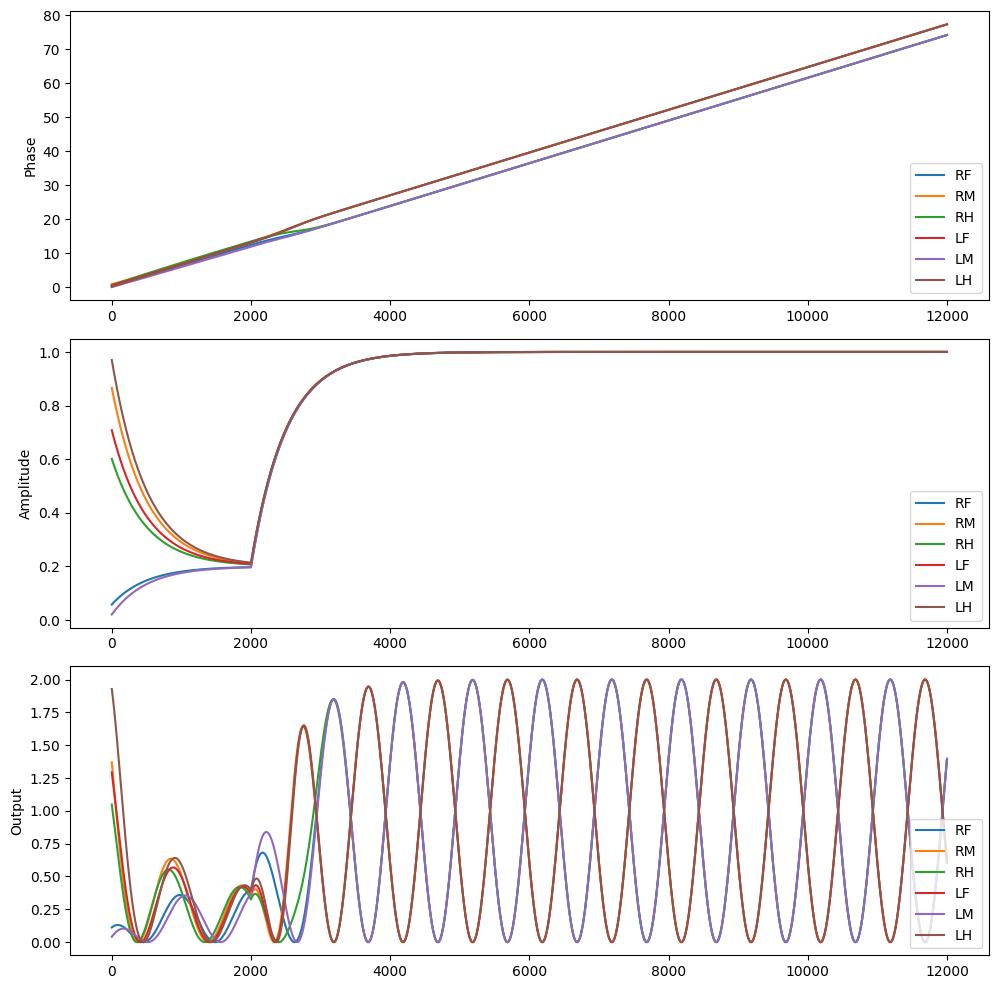

In [28]:
plot_phase_amp_output(phases, amplitudes, sine_output(phases, amplitudes), LEGS)

In [29]:
video_path = Path('kin_replay/video.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

0.02